In [42]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import coral_ordinal as coral
import condor_tensorflow as condor

In [125]:
class RegMethod:
    NORMAL = "normal"  #
    CORAL = "coral"
    CONDOR = "condor"

config = {
    "regression_method": RegMethod.CORAL,
    "num_classes": 10,
    "input_shape": (28, 28),
    "learning_rate": 0.05,
    "batch_size": 128,
    "num_epochs":5
}

In [126]:
(X, y), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train, X_val, y_train, y_val = \
  train_test_split(X, y, test_size = 5000, random_state = 4)

train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        tf.cast(X_train[..., tf.newaxis] / 255, tf.float32),
        tf.cast(y_train, tf.int64)
    )
)
train_dataset=train_dataset.shuffle(1000).batch(config["batch_size"])

val_dataset = tf.data.Dataset.from_tensor_slices(
    (
        tf.cast(X_val[..., tf.newaxis] / 255, tf.float32),
        tf.cast(y_val, tf.int64)
    )
)
val_dataset=val_dataset.shuffle(1000).batch(config["batch_size"])


test_dataset = tf.data.Dataset.from_tensor_slices(
    (
        tf.cast(X_test[..., tf.newaxis] / 255, tf.float32),
        tf.cast(y_test, tf.int64)
    )
)
test_dataset = test_dataset.batch(config["batch_size"])

# X_val = X_val[...,tf.newaxis] / 255
# X_test = X_test[...,tf.newaxis] / 255


In [127]:
def build_model(config):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=config["input_shape"]),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation="relu"), 
        tf.keras.layers.Dropout(0.1)
    ])
    
    if config["regression_method"] == RegMethod.NORMAL:
        model.add(tf.keras.layers.Dense(config["num_classes"], activation="softmax"))
        model._name="normal_classification_mlp_model"
        
        model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate=config["learning_rate"]),
            loss = tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=["accuracy", "mae"]
        )
        
    elif config["regression_method"] == RegMethod.CORAL:
        model.add(coral.CoralOrdinal(config["num_classes"]))  # No activation is needed
        model._name="coral_ordinal_regression_mlp_model"

        
        model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate=config["learning_rate"]),
            loss = coral.OrdinalCrossEntropy(num_classes = config["num_classes"]),
            metrics = [coral.MeanAbsoluteErrorLabels()]
        )

        
    elif config["regression_method"] == RegMethod.CONDOR:
        model.add(tf.keras.layers.Dense(config["num_classes"]-1))  # No activation is needed.
        model._name="condor_ordinal_regression_mlp_model"
        
        model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate=config["learning_rate"]),
            loss = condor.SparseCondorOrdinalCrossEntropy(),
            metrics = [condor.SparseOrdinalMeanAbsoluteError()]
        )
    else:
        raise ValueError("Choose a right method.")
        
        
    model.summary()
    
    
    return model

In [128]:
model = build_model(config=config)

Model: "coral_ordinal_regression_mlp_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_17 (Flatten)        (None, 784)               0         
                                                                 
 dense_49 (Dense)            (None, 128)               100480    
                                                                 
 dropout_34 (Dropout)        (None, 128)               0         
                                                                 
 dense_50 (Dense)            (None, 32)                4128      
                                                                 
 dropout_35 (Dropout)        (None, 32)                0         
                                                                 
 coral_ordinal_1 (CoralOrdi  (None, 9)                 41        
 nal)                                                            
                                

In [ ]:
history = model.fit(
    train_dataset,
    epochs = config["num_epochs"],
    validation_data = val_dataset,
    callbacks = [tf.keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)]
)

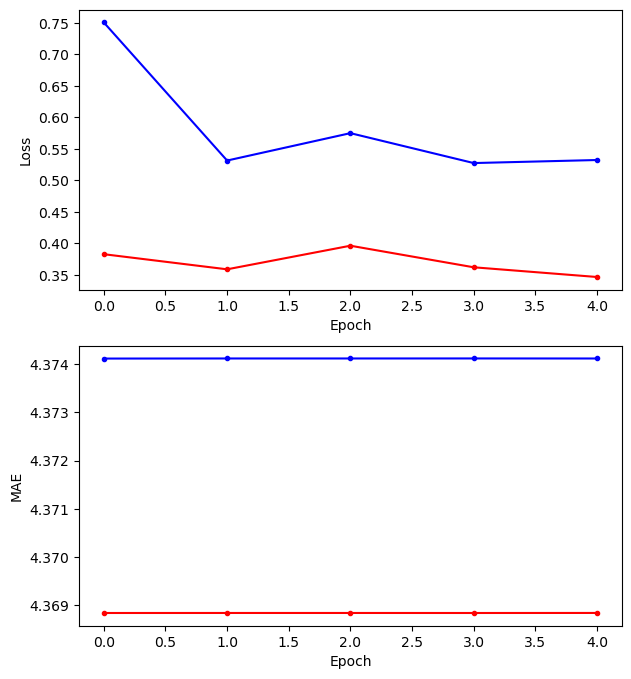

In [116]:
if config["regression_method"]== RegMethod.NORMAL:
    mae_labels = ["mae", "val_mae"]
else:
    mae_labels = ["mean_absolute_error_labels", "val_mean_absolute_error_labels"]
    

plt.figure(figsize=(7,8))
plt.subplot(211)
plt.plot(history.history["loss"], "b.-")
plt.plot(history.history["val_loss"], "r.-")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(212)
plt.plot(history.history[mae_labels[0]], "b.-")
plt.plot(history.history[mae_labels[1]], "r.-")
plt.xlabel("Epoch")
plt.ylabel("MAE")

plt.show()

In [123]:
def evaluate_model(model, reg_method, test_dataset):

    print(model.evaluate(test_dataset))
        
    ordinal_logits = model.predict(test_dataset)
    
    if reg_method == RegMethod.CONDOR:
        tensor_probs = condor.ordinal_softmax(ordinal_logits)
        prob = tensor_probs.numpy()
    elif reg_method == RegMethod.CORAL:
        tensor_probs = coral.ordinal_softmax(ordinal_logits)
        prob = tensor_probs.numpy()
    else:
        prob = ordinal_logits
        
    return prob

79/79 [==============================] - 0s 2ms/step - loss: 0.3383 - accuracy: 0.9209 - mae: 4.3630
[0.33829164505004883, 0.9208999872207642, 4.363000392913818]
79/79 [==============================] - 0s 2ms/step


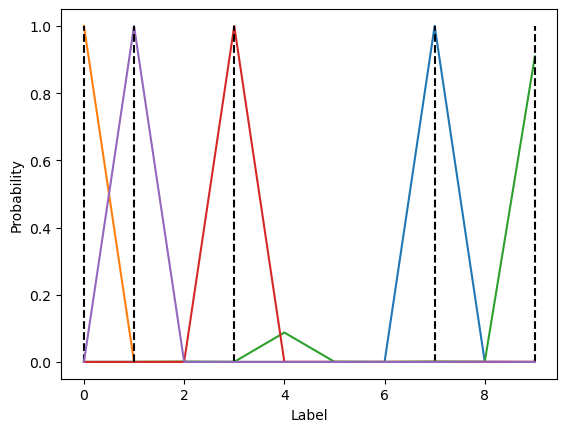

In [124]:
prob = evaluate_model(model=model, reg_method=config["regression_method"], test_dataset=test_dataset)

for i in range(5):
    plt.plot(prob[i*10, :])
    plt.plot([y_test[i*10], y_test[i*10]], [0, 1], "k--")
plt.xlabel("Label")
plt.ylabel("Probability")
plt.show()